# Computer Vision - DL assignment

Gianluca Vico - i6183186 \\
Alexandra Gianzina - i6294354

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import gc
sns.set_theme(context="poster", style="darkgrid", palette="colorblind")

torch.manual_seed(1)
np.random.seed(1)
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.deterministic = True
print("Device:", device)

Device: cuda


## Upload the data
If the dataset is not loaded in Google Cobal run these cell.

If the dataset is already in the working directory you can skip this part

### Method 1: upload the zip file

In [ ]:
# If you run this notebook in google colab, run this cell to upload the dataset
from google.colab import files
uploaded = files.upload()

In [ ]:
!unzip archive.zip

### Method 2: download from Kaggle

In [ ]:
# Upload kaggle.json file to be able to download from Kaggle
# To get the kaggle.json file you have to go in your kaggle account and generate a new API token
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ashishpatel26/facial-expression-recognitionferchallenge
!unzip facial-expression-recognitionferchallenge.zip

 98% 95.0M/96.6M [00:00<00:00, 166MB/s]
100% 96.6M/96.6M [00:00<00:00, 156MB/s]
Archive:  facial-expression-recognitionferchallenge.zip
  inflating: Submission.csv          
  inflating: fer2013/fer2013/README  
  inflating: fer2013/fer2013/fer2013.bib  
  inflating: fer2013/fer2013/fer2013.csv  


## Load and prepare the dataset

In [ ]:
# Path to the csv file
df= pd.read_csv("fer2013/fer2013/fer2013.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [ ]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


The dataset has three sets.
Each image is given as a single string. We need to split it and convert to a tensor with the correct shape.

In [ ]:
df["Usage"].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [ ]:
df_train = df[df['Usage']=='Training']
df_val = df[df['Usage']=='PrivateTest']
df_test = df[df['Usage']=='PublicTest']

In [ ]:
def extract_images(df, shape=(48,48)):
    """
    Args:
        df: pandas DataFrame from the FER2013 dataset
        shape: shape of images
    Returns:
        Tensor containing all the images (shape: (#images, shape[0], shape[1]))
        The images have type float32 and range [0, 1]
    """
    imgs = [None for i in range(len(df))]
    for i in range(len(df)):
        imgs[i] = np.array(df.iloc[i]["pixels"].split(" "), dtype=int).reshape(shape) / 255
    imgs = np.array(imgs)
    return torch.from_numpy(imgs).float().unsqueeze(1) # add channel dimension

In [ ]:
train_imgs = extract_images(df_train)
val_imgs = extract_images(df_val)
test_imgs = extract_images(df_test)

In [ ]:
train_imgs.shape

torch.Size([28709, 1, 48, 48])

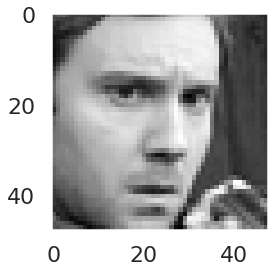

Img. shape: torch.Size([1, 48, 48])


In [ ]:
plt.imshow(train_imgs[0][0], cmap="gray")
plt.grid(False)
plt.show()
print("Img. shape:", train_imgs[0].shape)

In [ ]:
def extract_labels(df):    
    """
    Args:
        df: pandas DataFrame from the FER2013 dataset        
    Returns:
        Tensor containing all the labels (shape: (#images))        
    """
    return torch.from_numpy(df["emotion"].values)

# label_to_text[labels] -> this returns an array with the labels as text
label_to_text = np.array(["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"])
n_labels = 7

In [ ]:
train_labels = extract_labels(df_train)
val_labels = extract_labels(df_val)
test_labels = extract_labels(df_test)

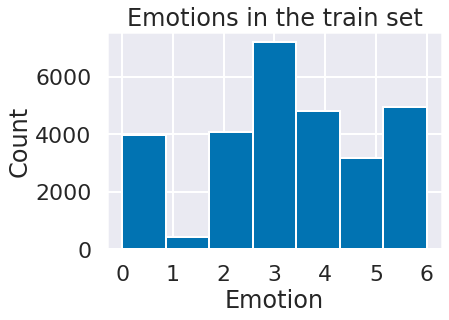

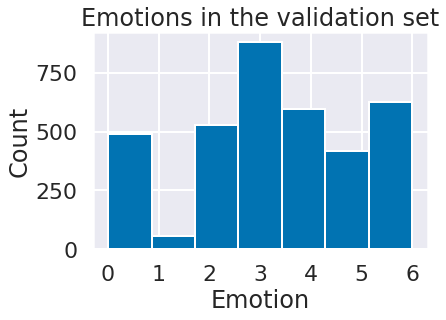

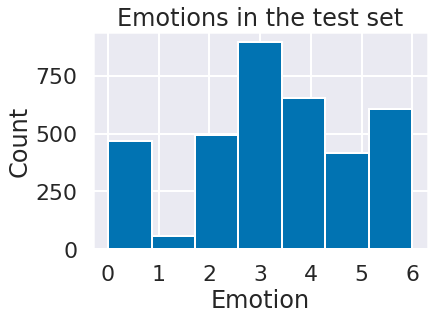

In [ ]:
plt.hist(np.array(train_labels), bins=n_labels)
plt.title("Emotions in the train set")
plt.xticks(range(n_labels))
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

plt.hist(np.array(val_labels), bins=n_labels)
plt.title("Emotions in the validation set")
plt.xticks(range(n_labels))
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

plt.hist(np.array(test_labels), bins=n_labels)
plt.title("Emotions in the test set")
plt.xticks(range(n_labels))
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

The labels have similar distribution in the three set. However, the dataset is unbalanced (for example, 1:Disgust is not well represented and most of the labels are 3:Happy).

In [ ]:
# Create the dataset
batch = 256
train_data = TensorDataset(train_imgs, F.one_hot(train_labels, n_labels).float())
val_data = TensorDataset(val_imgs, F.one_hot(val_labels, n_labels).float())
test_data = TensorDataset(test_imgs, F.one_hot(test_labels, n_labels).float())

train_set = DataLoader(train_data, batch_size=batch, shuffle=True)
val_set = DataLoader(val_data, batch_size=batch, shuffle=False)  # No need to shuffle to validation and testing
test_set = DataLoader(test_data, batch_size=batch, shuffle=False)
large_set = DataLoader(ConcatDataset([train_data, val_data, test_data]), batch_size=batch, shuffle=True)  # Use this to retrain the final model

## Define the model

We will compare different models. 

The first one is a small convolutional network with convolution and max pooling.
This model should not require much data to train.

The second model is deeper and it uses residual blocks. This model requires more data than the previous one since it has more parameters.

The last model connects the first layers with some deeper layers in a way similar to U-net.

All the models end with max pooling + linear + softmax to perform the classification. Max pooling is used to have a desired number of dimenstions at the end of the convolutional part. Linear will scale the output and softmax generates the label distribution.


In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
    
    def get_prob(self, x):
        x = self(x)
        return F.softmax(x, 1)

    def get_class(self, x):
        return self.get_prob(x).argmax(axis=-1)

    def output_to_class(self, output):
        return F.softmax(output, 1).argmax(axis=-1)

class CNNModel1(CNNClassifier):
    def __init__(self, n_label=n_labels):
        super().__init__()
        # conv + max pooling + conv + maxpooling + linear
        self.layers = nn.Sequential(
            nn.Conv2d(1, 4, 3), 
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(4, 7, 3),
            nn.ReLU(),
            nn.MaxPool2d(2), # 7 x 10 x 10
            nn.Flatten(1),
            nn.Linear(7*10*10, 250),
            nn.ReLU(),
            nn.Linear(250, 50),
            nn.ReLU(),
            nn.Linear(50, n_labels)
        )

    def forward(self, x):
        return self.layers(x)


class CNNModel2(CNNClassifier):
    def __init__(self, n_label=n_labels):
        super().__init__()
        # res block * 3 + maxpooling + linear        
        self.res1 = nn.Sequential(
            nn.Conv2d(1, 4, 3, padding=1), 
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Conv2d(4, 4, 3, padding=1), 
            nn.BatchNorm2d(4),
        ) # 4x44x44
        self.max1 = nn.MaxPool2d(2)  # 8x23x23
        self.conv1 = nn.Conv2d(4, 8, 3)
        self.res2 = nn.Sequential(
            nn.Conv2d(8, 8, 3, padding=1), 
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 8, 3, padding=1), 
            nn.BatchNorm2d(8),
        ) # 8x18x18
        self.max2 = nn.MaxPool2d(2)  # 8x23x23

        self.linear = nn.Sequential(
            nn.Linear(8*11*11, 100),
            nn.ReLU(),
            nn.Linear(100, n_labels)
        )

    def forward(self, x):
        out = self.res1(x)
        x = out + x
        x = F.relu(x)                
        x = self.max1(x)
        x = self.conv1(x)
        out = self.res2(x)
        x = out + x
        x = F.relu(x)
        x = self.max2(x)
        x = x.flatten(1)
        return self.linear(x)
        

class CNNModel3(CNNClassifier):
    def __init__(self, n_label=n_labels):
        super().__init__()
        # Connect first layers with last layers. U-net
        self.conv1 = nn.Conv2d(1, 4, 3, stride=2, padding=1) # Connect to conv5
        self.conv2 = nn.Conv2d(4, 8, 3, stride=2, padding=1) # Connect to conv4
        self.conv3 = nn.Conv2d(8, 16, 3, stride=2, padding=1) 
        self.up1 = nn.Upsample(scale_factor=2)
        self.conv4 = nn.Conv2d(16+8, 12, 3, padding=1)  # filter size 1 -> same size
        self.up2 = nn.Upsample(scale_factor=2)
        self.conv5 = nn.Conv2d(12+4, 8, 3, padding=1) 
        self.max = nn.MaxPool2d(3)
        self.lin = nn.Sequential(
            nn.Linear(512, 50),
            nn.ReLU(),
            nn.Linear(50, n_labels)
        )

        self.layers = nn.ModuleList([self.conv1,
                                    self.conv2,
                                    self.conv3,
                                    self.conv4,
                                    self.conv5,
                                    self.up1,
                                    self.up2,
                                    self.max,
                                    self.lin])
        
    def forward(self, x):
       out1 = F.relu(self.conv1(x))
       out2 = F.relu(self.conv2(out1))
       x = F.relu(self.conv3(out2))
       x = self.up1(x)
       # stack x and out2
       x = torch.cat((x, out2), 1)
       x = F.relu(self.conv4(x))
       x = self.up2(x)
       # stack x and out 1
       x = torch.cat((x, out1), 1)
       x = F.relu(self.conv5(x))
       x = self.max(x)
       x = x.flatten(1)
       return self.lin(x)


class DummyClassifier(CNNClassifier):
    def __init__(self):
        super().__init__()
        self.device = "cpu"        

    def forward(self, x):
        assert tuple(x.shape[1:]) == (1, 48, 48) , f"Shape is {x.shape[1:]}"      
        return torch.tensor([[0, 0, 0, 1, 0, 0, 0] for i in range(x.shape[0])]).float().to(self.device)
    
    def to(self, device):
        self.device = device
        return self

## Train & test

In [ ]:
def train(model, epochs, lr, train_set, val_set, optimizer_cls, criterion, name=""):
    history = []
    val_history = []
    val_accuracy = []
    
    optimizer = optimizer_cls(model.parameters(), lr = lr)

    epoch_loss = 0
    last_loss = 0
    best_loss = 100000
    val_loss = best_loss

    for e in range(epochs):
        model.train()  
        for i, data in enumerate(train_set):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.float().to(device)

            optimizer.zero_grad()            
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
                       
        last_loss = epoch_loss / i                        
        epoch_loss = 0
        history.append(last_loss)
        if val_set is not None:
            val_loss, accuracy, _, _, _, _ = test(model, val_set, criterion)
            val_history.append(val_loss)
            val_accuracy.append(accuracy)
        if (e) % 10 == 9:
            print('  epoch {} loss: {}'.format(e + 1, last_loss)) 
            print('  epoch {} validation loss: {}'.format(e + 1, val_loss))
            if val_set is not None:
                print('  epoch {} validation accuracy: {}'.format(e + 1, accuracy)) 
        

        if best_loss > val_loss:
            best_loss = last_loss
            torch.save(model, f"{name}_{e}.pt")   
    return history, val_history, val_accuracy
    

def test(model, test, criterion):
    model.eval()
    running_test_loss = 0.0
    y_pred = []
    y_true = []
    for i, test_data in enumerate(test):
        test_inputs, test_labels = test_data
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        test_outputs = model(test_inputs)
        test_loss = criterion(test_outputs, test_labels).item()
        running_test_loss += test_loss        
        y_pred.extend(model.output_to_class(test_outputs).detach().cpu().numpy())
        y_true.extend(test_labels.argmax(axis=-1).detach().cpu().numpy())
        
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred,  average="macro", zero_division=0)
    precision = precision_score(y_true, y_pred,  average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred,  average="macro", zero_division=0)
    confusion = confusion_matrix(y_true, y_pred)

    return running_test_loss / (i + 1), accuracy, recall, precision, f1, confusion

def plot_loss(train_loss, val_loss, title):
    fig, ax = plt.subplots(figsize=(15,8))
    ax.set_title(title)
    ax.plot(train_loss, label="Train loss")
    ax.plot(val_loss, label="Validation loss")
    ax.legend()
    plt.show()

def plot_accuracy(val_accuracy, title):
    fig, ax = plt.subplots(figsize=(15,8))
    ax.set_title(title)
    ax.plot(val_accuracy, label="Validation accuracy")    
    ax.legend()
    plt.show()

### Baseline

In [ ]:
dummy = DummyClassifier().to(device)
_, accuracy, recall, precision, f1, _ = test(dummy, test_set, nn.CrossEntropyLoss())
print("Baseline accuracy:", accuracy)
print("Baseline recall:", recall)
print("Baseline precision:", precision)
print("Baseline f1:", f1)

Baseline accuracy: 0.24937308442463083
Baseline recall: 0.14285714285714285
Baseline precision: 0.03562472634637583
Baseline f1: 0.05702816362941251


### Train

In [ ]:
# From pytorch forum
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
m1 = CNNModel1().to(device)
m2 = CNNModel2().to(device)
m3 = CNNModel3().to(device)

In [ ]:
print("Number of parameters - CNNModel1:", count_parameters(m1))
print("Number of parameters - CNNModel2:", count_parameters(m2))
print("Number of parameters - CNNModel3:", count_parameters(m3))

Number of parameters - CNNModel1: 188456
Number of parameters - CNNModel2: 99307
Number of parameters - CNNModel3: 31275


In [ ]:
epochs = 100
lr = 1e-3
print("Train Model 1")
history1, val_history1, val_accuracy1 = train(m1, epochs, lr, train_set, val_set, optim.Adam, nn.CrossEntropyLoss(), "model1")

Train Model 1
  epoch 10 loss: 1.4872826412320137
  epoch 10 validation loss: 1.4982876380284627
  epoch 10 validation accuracy: 0.42936751184173866
  epoch 20 loss: 1.2968279070087843
  epoch 20 validation loss: 1.418528151512146
  epoch 20 validation accuracy: 0.45723042630259125
  epoch 30 loss: 1.1044381803699903
  epoch 30 validation loss: 1.4376786470413208
  epoch 30 validation accuracy: 0.4566731680133742
  epoch 40 loss: 0.9104127303830215
  epoch 40 validation loss: 1.5151289145151774
  epoch 40 validation accuracy: 0.48815826135413765
  epoch 50 loss: 0.7453233732708863
  epoch 50 validation loss: 1.750884509086609
  epoch 50 validation accuracy: 0.47534132070214546
  epoch 60 loss: 0.5956190869744334
  epoch 60 validation loss: 2.0668120940526324
  epoch 60 validation accuracy: 0.4800780161604904
  epoch 70 loss: 0.4682575043823038
  epoch 70 validation loss: 2.5055992126464846
  epoch 70 validation accuracy: 0.46753970465310674
  epoch 80 loss: 0.3662876995014293
  epoch 8

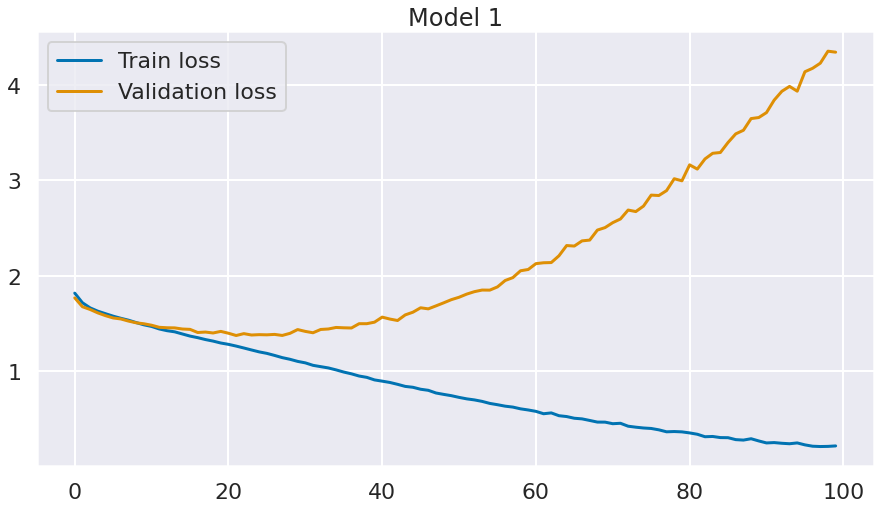

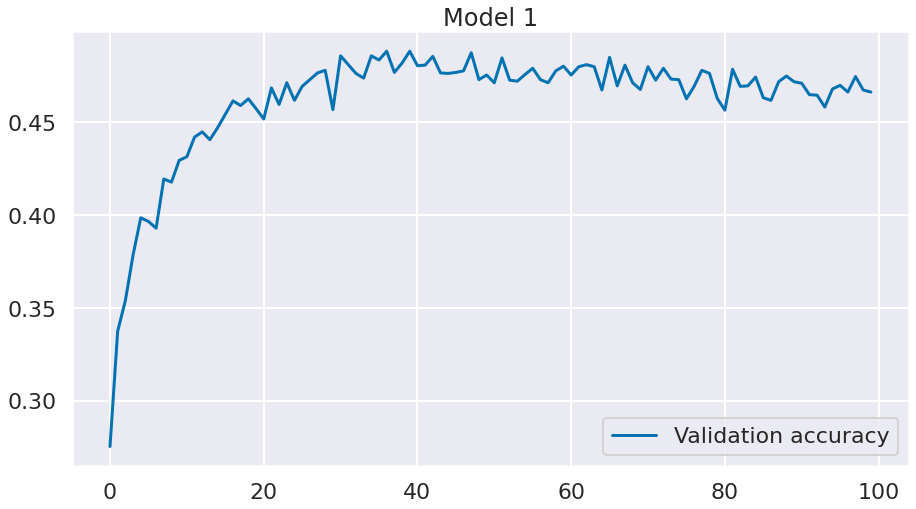

In [ ]:
plot_loss(history1, val_history1, "Model 1")
plot_accuracy(val_accuracy1, "Model 1")

In [ ]:
epochs = 100
lr = 1e-3
print("Train Model 2")
history2, val_history2, val_accuracy2 = train(m2, epochs, lr, train_set, val_set, optim.Adam, nn.CrossEntropyLoss(), "model2")

Train Model 2
  epoch 10 loss: 1.126938960914101
  epoch 10 validation loss: 1.3550952037175497
  epoch 10 validation accuracy: 0.4928949568124826
  epoch 20 loss: 0.8556504063308239
  epoch 20 validation loss: 1.550334906578064
  epoch 20 validation accuracy: 0.47952075787127335
  epoch 30 loss: 0.6455589953277793
  epoch 30 validation loss: 1.7088991244633993
  epoch 30 validation accuracy: 0.4917804402340485
  epoch 40 loss: 0.48431442358664106
  epoch 40 validation loss: 2.0684746980667112
  epoch 40 validation accuracy: 0.4803566453050989
  epoch 50 loss: 0.35659547096916605
  epoch 50 validation loss: 2.5036536872386934
  epoch 50 validation accuracy: 0.49122318194483144
  epoch 60 loss: 0.25993766502610277
  epoch 60 validation loss: 3.005157426993052
  epoch 60 validation accuracy: 0.4742268041237113
  epoch 70 loss: 0.18617399455979466
  epoch 70 validation loss: 3.624418767293294
  epoch 70 validation accuracy: 0.47645583728057955
  epoch 80 loss: 0.14390931690910033
  epoch 

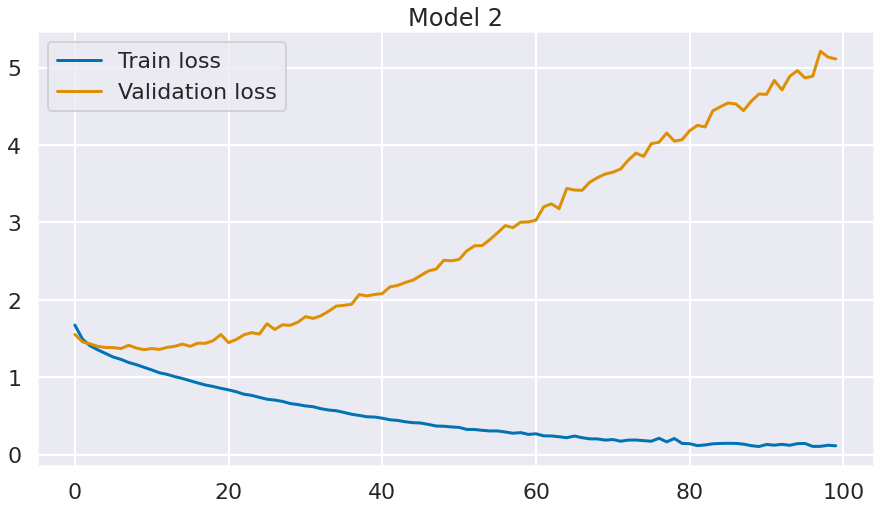

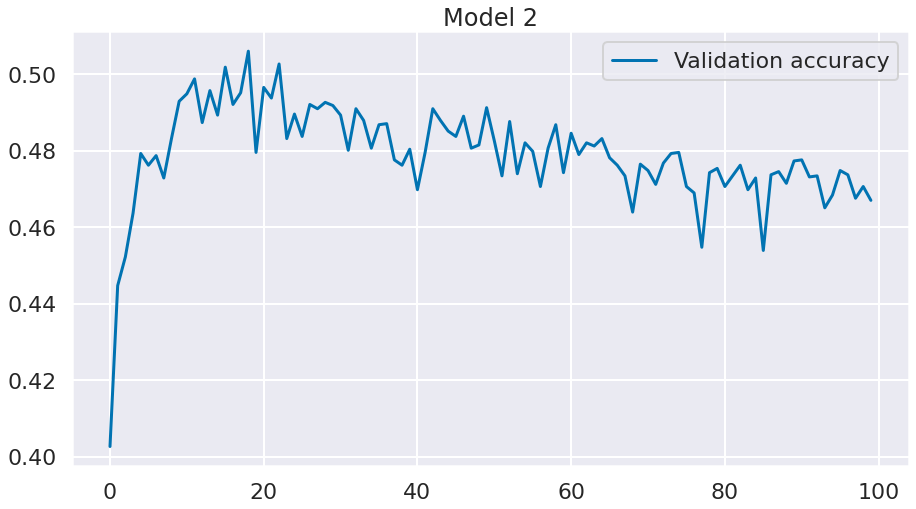

In [ ]:
plot_loss(history2, val_history2, "Model 2")
plot_accuracy(val_accuracy2, "Model 2")

In [ ]:
epochs = 100
lr = 1e-3
print("Train Model 3")
history3, val_history3, val_accuracy3 = train(m3, epochs, lr, train_set, val_set, optim.Adam, nn.CrossEntropyLoss(), "model3")

Train Model 3
  epoch 10 loss: 1.4968557081052236
  epoch 10 validation loss: 1.5076695362726846
  epoch 10 validation accuracy: 0.42741710782947895
  epoch 20 loss: 1.3606372848153114
  epoch 20 validation loss: 1.4328171968460084
  epoch 20 validation accuracy: 0.4488715519643355
  epoch 30 loss: 1.2800718833293234
  epoch 30 validation loss: 1.4431804577509562
  epoch 30 validation accuracy: 0.4416271942045138
  epoch 40 loss: 1.2190325228231293
  epoch 40 validation loss: 1.4177441438039144
  epoch 40 validation accuracy: 0.46029534689328505
  epoch 50 loss: 1.1703822995935167
  epoch 50 validation loss: 1.4416726589202882
  epoch 50 validation accuracy: 0.4619671217609362
  epoch 60 loss: 1.1218360768897193
  epoch 60 validation loss: 1.4528046290079752
  epoch 60 validation accuracy: 0.4625243800501532
  epoch 70 loss: 1.092155285179615
  epoch 70 validation loss: 1.485456355412801
  epoch 70 validation accuracy: 0.4739481749791028
  epoch 80 loss: 1.0654060201985496
  epoch 80 v

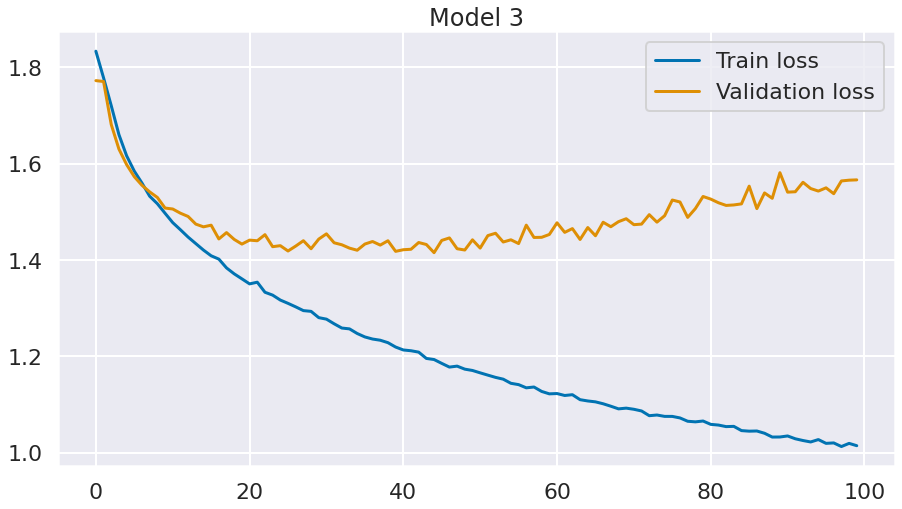

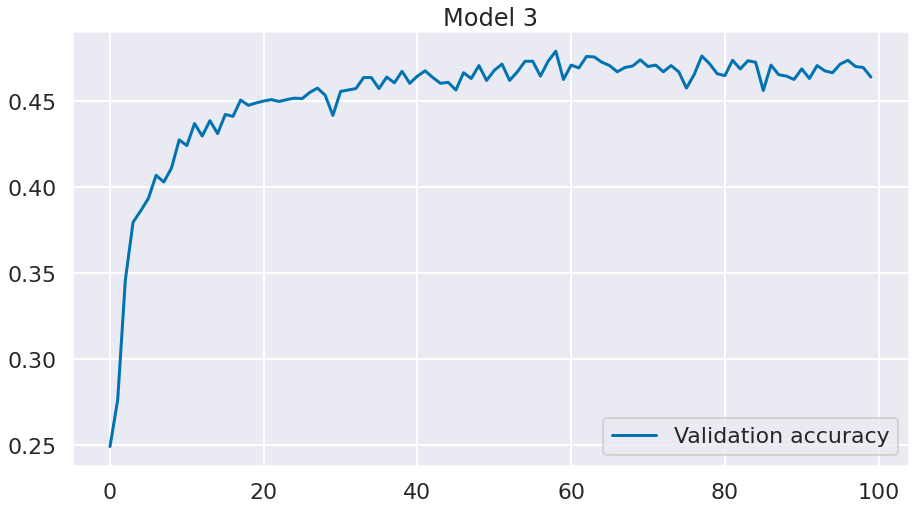

In [ ]:
plot_loss(history3, val_history3, "Model 3")
plot_accuracy(val_accuracy3, "Model 3")

### Test

In [ ]:
m1 = torch.load("model1_21.pt")
m1.eval()
m2 = torch.load("model2_11.pt")
m2.eval()
m3 = torch.load("model3_16.pt")
m3.eval()
""

''

In [ ]:
def print_report(name, accuracy, recall, precision, f1, confusion):
    print("------------------------------------------------------")
    print("Report", name)
    print("    Accuracy:", accuracy)
    print("    Recall:", recall)
    print("    Precision:", precision)
    print("    F1:", f1)
    print("    Confusion matrix:\n", confusion)
    print("------------------------------------------------------")

In [ ]:
_, accuracy1, recall1, precision1, f11, confusion1 = test(m1, test_set, nn.CrossEntropyLoss())
_, accuracy2, recall2, precision2, f12, confusion2 = test(m2, test_set, nn.CrossEntropyLoss())
_, accuracy3, recall3, precision3, f13, confusion3 = test(m3, test_set, nn.CrossEntropyLoss())

print_report("Model 1", accuracy1, recall1, precision1, f11, confusion1)
print_report("Model 2", accuracy2, recall2, precision2, f12, confusion2)
print_report("Model 3", accuracy3, recall3, precision3, f13, confusion3)

------------------------------------------------------
Report Model 1
    Accuracy: 0.47199777096684314
    Recall: 0.3993434720091091
    Precision: 0.46579146880825456
    F1: 0.4022803139536896
    Confusion matrix:
 [[178   2  32  98  66  16  75]
 [ 21   5   4  11   8   1   6]
 [ 88   1  97  89  98  53  70]
 [ 59   0  20 695  53  20  48]
 [124   0  54 135 211  28 101]
 [ 31   0  38  40  27 253  26]
 [ 89   1  31 120  91  20 255]]
------------------------------------------------------
------------------------------------------------------
Report Model 2
    Accuracy: 0.5123989969350794
    Recall: 0.4586392014854967
    Precision: 0.5030490955349479
    F1: 0.4691247532936926
    Confusion matrix:
 [[178   2  46  76  72  15  78]
 [ 16  15   3   8   7   0   7]
 [ 64   5 131  64  92  54  86]
 [ 37   0  25 711  32  19  71]
 [ 88   1  58 120 223  10 153]
 [ 28   3  36  28  17 268  35]
 [ 63   1  31 100  87  12 313]]
------------------------------------------------------
----------------

## Select and retrain the best model

In [ ]:
epochs = 11
best = CNNModel2().to(device)
lr = 1e-3
print("Train the final model")
history_final, val_history_final, val_accuracy_final = train(best, epochs, lr, large_set, None, optim.Adam, nn.CrossEntropyLoss(), "best_model")
torch.save(best, f"best_CNNModel2.pt")   

Train the final model
  epoch 10 loss: 1.1446177295276097
  epoch 10 validation loss: 100000


## Emotion recognition demo

**Note**: the webcam does not work on Google Colab, as it does not have direct access to it. This also needs a working webcam.

Here, we stream a video from the webcam and use a face recognition model from OpenCV to identify a face. Then we feed the face our model and we display a label. 

The code for the face detector and for showing the webcam video comes from here: https://towardsdatascience.com/how-to-detect-objects-in-real-time-using-opencv-and-python-c1ba0c2c69c0

In [ ]:
# Load the model for the demo
model = torch.load("best_CNNModel2.pt")

In [ ]:
def kill_cam(imcap):
    imcap.release()  # This might not work on Linux
    del imcap
    gc.collect()    # This does

def live_demo(model: CNNClassifier, video: str = None):
    """
    Args:
        model: emotion classifier model. It must be on the cpu
        video: if given, use this video for the demp
    Return:
        number of frames, number of faces detected, emotion detected each match

    Note:
        The video is processed at 15 FPS to ensure that the model can identify the emotions.
        It can work at higher FPSs but it depens on the hardware.
    """
    success = True
    frames = 0
    face_matches= 0
    emotions = []
    try:
        if video is None:
            imcap = cv2.VideoCapture(0)
        else:
            imcap = cv2.VideoCapture(video_path)
        imcap.set(cv2.CAP_PROP_FRAME_WIDTH, 640) # set width as 640
        imcap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480) # set height as 480
        imcap.set(cv2.CAP_PROP_FPS, 15)
        # Face recognition model
        faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
        
        #model = dummy.to("cpu")
 
        print("Press 'q' to stop the demo")

        while success or (video is None): # Webcam: forever / Video: until we can read
            success, img = imcap.read() # capture frame from video    
            frames += 1

            # converting image from color to grayscale 
            if success:
                imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                # Getting corners around the face
                # 1.3 = scale factor, 5 = minimum neighbor can be detected
                faces = faceCascade.detectMultiScale(imgGray, 1.3, 5)  

                # drawing bounding box around face
                for (x, y, w, h) in faces:
                    img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255,   0), 3)    # displaying image with bounding box
                    crop = imgGray[y:y+h,x:x+w]
                    crop = cv2.resize(crop, (48, 48))
                    crop = (torch.tensor(crop).float()/255)
                    crop = crop.view(1, 1, *crop.shape)
                    emotion = model.get_class(crop).item()
                    label = label_to_text[emotion]
                    emotions.append(label)
                    cv2.putText(img, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

                    face_matches += 1
                
                cv2.putText(img, "Press 'q' to exit", (0, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
                                
                cv2.imshow('face_detect', img)    # loop will be broken when 'q' is pressed on the keyboard
                
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
    finally:
        kill_cam(imcap)
        cv2.destroyAllWindows()
    return frames, face_matches, emotions

def get_freq(emotions):
    df = pd.value_counts(emotions).to_frame()
    df.columns = ["Frequency"]
    df["Relative Frequency"] = df["Frequency"] / len(emotions)
    return df

### Import the self made video

In [ ]:
# If you run this notebook in google colab, run this cell to upload the video
from google.colab import files
video_uploaded = files.upload()

Saving amber.mp4 to amber (1).mp4


In [ ]:
# Change this. Use the correct path to the file
video_path = "/content/amber.mp4"

In [ ]:
# This might print a lot of warning
frames, faces, emotions = live_demo(model.to("cpu"), video_path)

frame 651 extracted successfully


In [ ]:
print("Frames:", frames)
print("Faces:", faces)
print("Emotions:") 
get_freq(emotions)

### Take video capture in real time

In [ ]:
# This might print a lot of warning
frames, faces, emotions = live_demo(model.to("cpu"))

In [ ]:
print("Frames:", frames)
print("Faces:", faces)
print("Emotions:") 
get_freq(emotions)

Frames: 1461
Faces: 1359
Emotions:


,Frequency,Relative Frequency
Neutral,715,0.526122
Sad,474,0.348786
Happy,100,0.073584
Fear,50,0.036792
Angry,19,0.013981
Surprise,1,0.000736


## Visualization

We select the best model and we plot both the filters and the activation map of each layer.

The diffent channels of the same filter are displayed on the same row


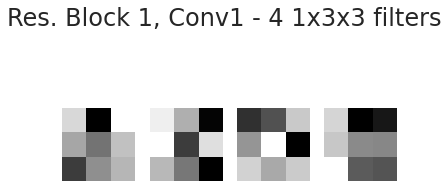

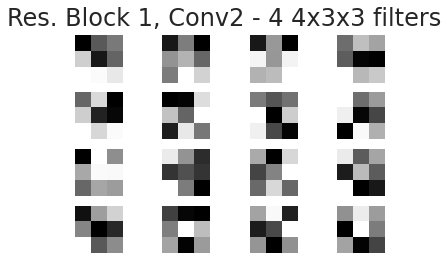

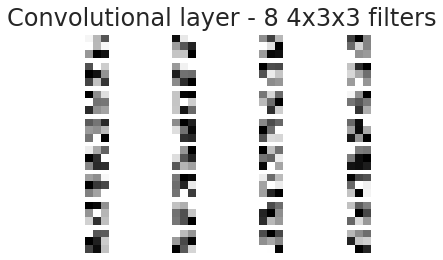

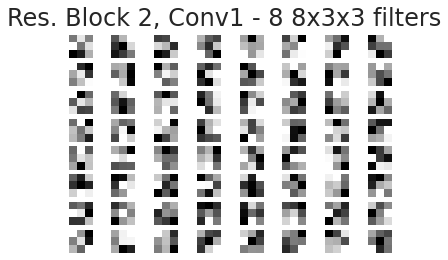

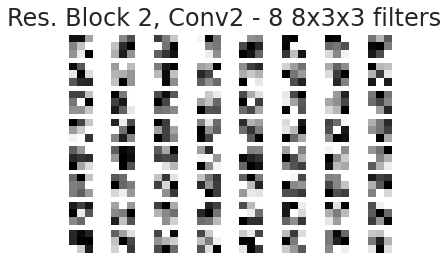

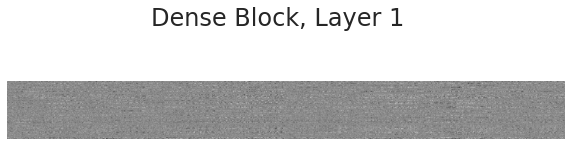

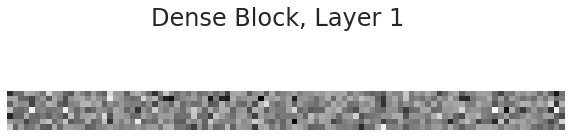

In [ ]:
def show_filters(ax, weights, filters, channels):
    for i in range(filters):         
        for j in range(channels):            
            ax[i, j].imshow(weights[i, j], cmap="gray")            
            ax[i, j].grid(False)
            ax[i, j].axis(False)

def filter_CNNClassifier2(model):
    # Residual block 1, layer 1
    fig, ax = plt.subplots(1, 4)
    fig.suptitle("Res. Block 1, Conv1 - 4 1x3x3 filters", fontsize=24)
    weight = model.res1[0].weight.detach().cpu()
    for i in range(4):  # More compact than the other layers
        ax[i].imshow(weight[i, 0], cmap="gray")
        ax[i].grid(False)
        ax[i].axis(False)
    
    plt.show()

    # Residual block 1, layer 4
    fig, ax = plt.subplots(4, 4)
    fig.suptitle("Res. Block 1, Conv2 - 4 4x3x3 filters", fontsize=24)
    show_filters(ax, model.res1[3].weight.detach().cpu(), 4, 4)
    plt.show()

    # Convolutional
    fig, ax = plt.subplots(8, 4)
    fig.suptitle("Convolutional layer - 8 4x3x3 filters", fontsize=24)
    show_filters(ax, model.conv1.weight.detach().cpu(), 8, 4)
    plt.show()

    # Residual block 2, layer 1
    fig, ax = plt.subplots(8, 8)
    fig.suptitle("Res. Block 2, Conv1 - 8 8x3x3 filters", fontsize=24)
    show_filters(ax, model.res2[0].weight.detach().cpu(), 8, 8)
    plt.show()

    # Residual block 2, layer 4
    fig, ax = plt.subplots(8, 8)
    fig.suptitle("Res. Block 2, Conv2 - 8 8x3x3 filters", fontsize=24)
    show_filters(ax, model.res2[3].weight.detach().cpu(), 8, 8)
    plt.show()

    # Dense block, layer 1
    fig, ax = plt.subplots(1, 1, figsize=(10,3))
    fig.suptitle("Dense Block, Layer 1", fontsize=24)
    ax.imshow(model.linear[0].weight.detach().cpu(), cmap="gray")
    ax.grid(False)
    ax.axis(False)
    plt.show()

    # Dense block, layer 2
    fig, ax = plt.subplots(1, 1, figsize=(10,3))
    fig.suptitle("Dense Block, Layer 1", fontsize=24)
    ax.imshow(model.linear[2].weight.detach().cpu(), cmap="gray")
    ax.grid(False)
    ax.axis(False)
    plt.show()
print("The diffent channels of the same filter are displayed on the same row")
filter_CNNClassifier2(model)

In [ ]:
def activation_CNNClassifier2(model, img):
    activations = {}
    x = img.unsqueeze(0).to(device)
    # From the forward method
    out = model.res1(x)
    x = out + x
    x = F.relu(x)      
    activations["residual block 1"] = x  
    x = model.max1(x)
    x = model.conv1(x)
    activations["convolution"] = x
    out = model.res2(x)
    x = out + x
    x = F.relu(x)
    activations["residual block 2"] = x  
    x = model.max2(x)
    x = x.flatten(1)
    activations["output"] = model.linear(x)

    return {k:v.detach().cpu() for k,v in activations.items()}

def plot_activations(model, img):
    acts = activation_CNNClassifier2(model, img)
    for k, v in acts.items():
        map = v.squeeze()
        if len(map.shape) == 1:
            map = map.unsqueeze(0)
            map = map.unsqueeze(0)
        fig, ax = plt.subplots(1, map.shape[0], figsize=(10,4))
        if type(ax) != np.ndarray:
            ax = [ax]
        fig.suptitle(f"Activation - {k}", fontsize=24)
        for i in range(map.shape[0]):            
            ax[i].imshow(map[i], cmap="gray")
            ax[i].grid(False)
            ax[i].axis(False)
        plt.show()

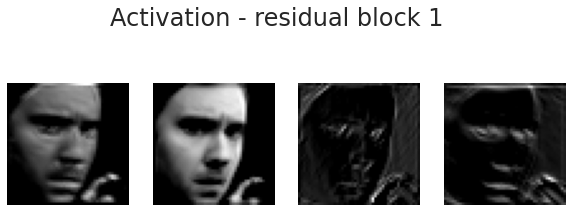

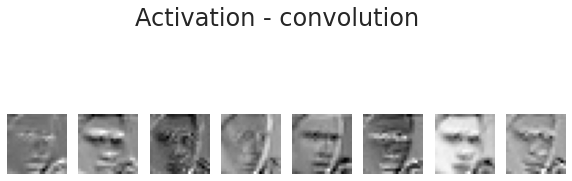

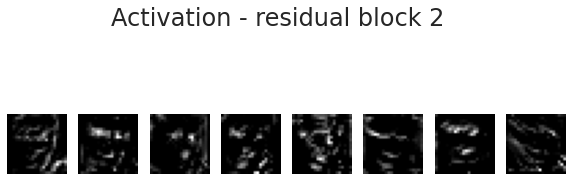

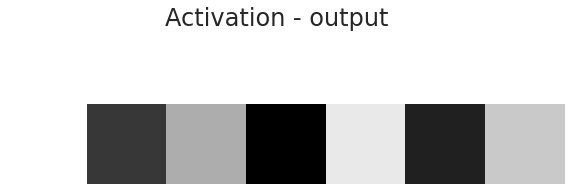

In [ ]:
plot_activations(model, train_data[0][0])

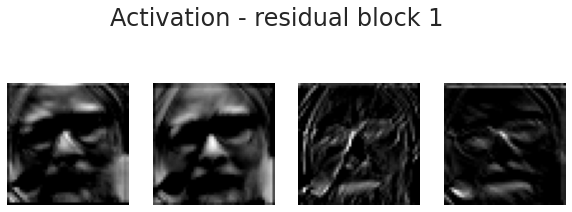

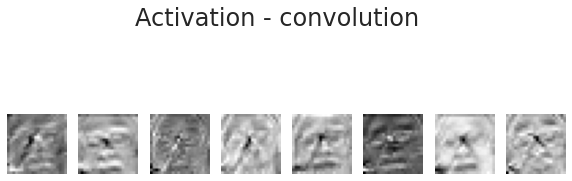

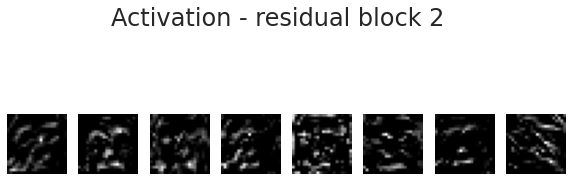

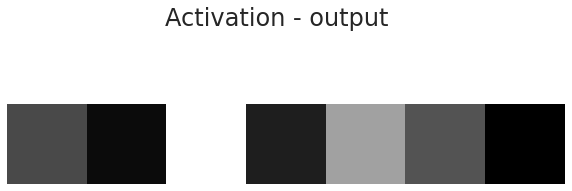

In [ ]:
plot_activations(model, train_data[1][0])